# Detecção de Fraudes em Cartões de Crédito

Neste projeto, iremos abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. Apenas no Brasil, cerca de 12,1 milhões de pessoas já foram vítimas de algum tipo de fraude financeira no último ano. Traduzindo em valores, os golpes financeiros ultrapassaram a cifra de R$ 1,8 bilhão de prejuízo por ano para os últimos 12 meses.

<p align=center>
<img src="https://images.unsplash.com/photo-1592772874383-d08932d29db7?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=699&q=80" width="60%"></p>

Dentra essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acaretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*. 

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de Reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## Importando os Dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

<p align=center>
<img src="https://images.unsplash.com/photo-1620714223084-8fcacc6dfd8d?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1051&q=80" width="50%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [10]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
model = LogisticRegression()


from imblearn.under_sampling import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

Para facilitar a aquisição dos dados, criei um *link* com acesso direto ao `csv`. Com isso, basta importar o conjunto de dados usando o método `pd.read_csv()`.

In [11]:
# importar os dados para um dataframe
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

df = pd.read_csv(file_path)

# dimensões do conjunto original
print("Dimensões do Conjunto Original: ", df.shape)

# criando o conjunto de teste
test = df.sample(frac=0.15, random_state=0)

# drop das linhas de teste
df = df.drop(test.index)

# verificando o conjunto
print("Dimensões do Conjunto de Teste: ", test.shape)
print("Dimensões do Conjunto de Treino: ", df.shape)

Dimensões do Conjunto Original:  (284807, 31)
Dimensões do Conjunto de Teste:  (42721, 31)
Dimensões do Conjunto de Treino:  (242086, 31)


Com os dados importados para dentro de uma estrutura *Dataframe* - e não havendo a necessidade de mais nenhum ajuste ou configuração nesta etapa, pode-se iniciar uma análise exploratória dos dados a fim de preparar um modelo de *Machine Learning*.

## Análise Exploratória

Apenas olhando as cinco primeiras entradas é possível tirar algumas conclusões:

* As 5 primeiras entradas permitem entender como a transformação PCA deixou as *features* descaracterizadas (anônimas) e em valores numéricos. Para saber mais sobre PCA, [clique neste *link*](http://www2.ic.uff.br/~aconci/PCA-ACP.pdf).

* As colunas `Time` e `Amount` foram preservadas, mantendo seu valor original.

* A variável alvo está representada na coluna `Class`, onde:
    * **0:** Transação normal; e
    * **1:** Transação fraudulenta;

In [12]:
# ver as primeiras entradas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Verificando abaixo o resumo estatístico, por meio do método `describe()`, podemos confirmar que as variáveis relativas aos componentes principais (transformação PCA) não têm nenhuma discrepância aparente, bem como a coluna `Time`.

Em relação à variável `Amount`, nota-se que o valor médio de transações (considerando ambas as classes) é 88.34, mediana igual a 22.00 e desvio padrão de 250.12. Atingindo o valor máximo de 25691.16, a maioria das transações financeiras é composta em sua maioria por quantias menores - como esperado.



In [13]:
# ver o resumo estatístico
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,...,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000,242086.000000
mean,94857.597379,0.001456,-0.000800,-0.001004,0.000647,-0.000986,-0.001196,-0.000033,-0.000416,-0.000725,...,-0.000015,0.000606,-0.000482,0.000199,0.000048,-0.000269,-0.000727,0.000065,88.612429,0.001727
std,47490.660832,1.956513,1.654883,1.514580,1.417228,1.366284,1.326879,1.223095,1.199718,1.099350,...,0.734189,0.726284,0.629651,0.605150,0.521574,0.482084,0.401490,0.327734,247.655020,0.041517
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.822684,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54234.000000,-0.920406,-0.598659,-0.893374,-0.848236,-0.693615,-0.769025,-0.553805,-0.208857,-0.645058,...,-0.228492,-0.542962,-0.161941,-0.354494,-0.316853,-0.327387,-0.070744,-0.052903,5.662500,0.000000
50%,84747.000000,0.019230,0.064567,0.177607,-0.018959,-0.054544,-0.274310,0.040344,0.022160,-0.051370,...,-0.028987,0.007162,-0.011175,0.040764,0.017175,-0.052337,0.001131,0.011209,22.000000,0.000000
75%,139362.000000,1.316034,0.803174,1.026561,0.743691,0.611455,0.397688,0.570104,0.327186,0.597195,...,0.187064,0.529814,0.147358,0.439320,0.350795,0.241214,0.090776,0.078234,77.580000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.801666,23.917837,44.054461,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


Quanto à qualidade do *dataset*, este não apresentou nenhum valor ausente ou 

1.   Item da lista
2.   Item da lista

que demandasse uma etapa de limpeza. Na função abaixo, perceba que o maior valor por coluna para valores nulos é zero, o que confirma que não há valores ausentes.

In [14]:
# ver se há valores ausentes
df.isnull().sum().max()

0

Como é [informado na descrição dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), as entradas relativas à transações fraudulentas correspondem a 0,17% do total.

O gráfico de barras mostra como essa discrepância se torna nítida e visível. Na prática, isso interfere no desempenho do modelo, e será necessário fazer um balanceamento dos dados antes de alimentar o modelo final de classificação.

0    241668
1       418
Name: Class, dtype: int64

Fraudes representam 0.1727% do dataset.



C:\Users\joao\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



[]

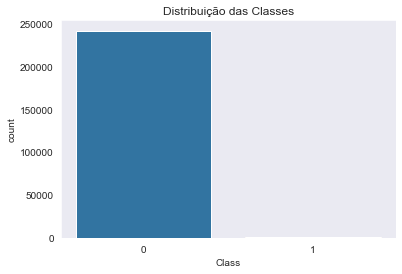

In [15]:
# ver o balanceamento das classes
print(df.Class.value_counts())
print("\nFraudes representam {:.4f}% do dataset.\n".format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

# plotar gráfico de barras para as Classes
fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição das Classes')
plt.plot()

Plotou-se também dois gráficos a fim de comparar as distribuições das 2 classes ao longo da dimensão tempo (`Time`). No entanto, não foi identificada nenhum informação a partir das distribuições de frequência abaixo.

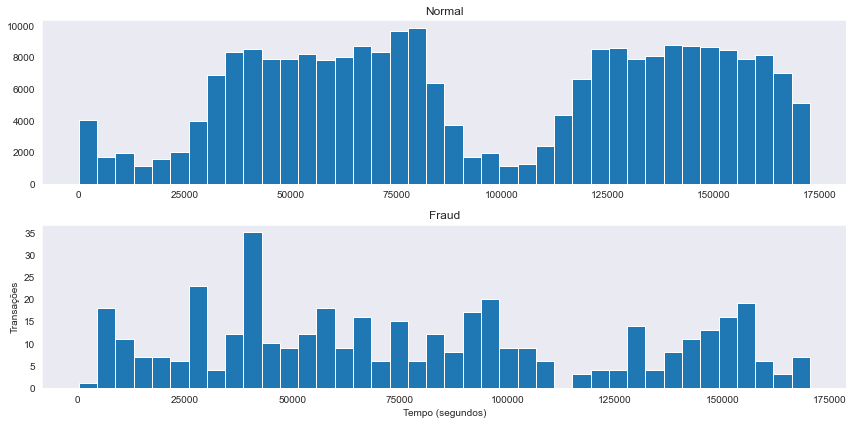

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

num_bins = 40

ax[0].hist(df.Time[df.Class == 0], bins=num_bins)
ax[0].set_title('Normal')

ax[1].hist(df.Time[df.Class == 1], bins=num_bins)
ax[1].set_title('Fraud')

plt.xlabel('Tempo (segundos)')
plt.ylabel('Transações')
plt.tight_layout()

Seguindo a análise exploratória, plotou-se os *boxplots* para ver se há alguma diferença no padrão transações em relação à dimensão `Amount`.

De uma maneira geral, percebe-se uma distribuição diferente para as duas classes, o que provavelmente irá contribuir para o treinamento do modelo de *machine learning*.

C:\Users\joao\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


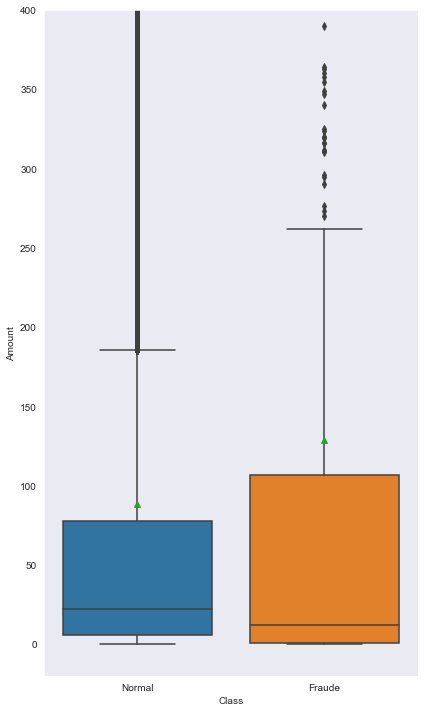

In [8]:
fig, ax = plt.subplots(figsize=(6,10), sharex=True)

sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)
plt.ylim((-20, 400))
plt.xticks([0, 1], ['Normal', 'Fraude'])

plt.tight_layout()

As informações estatísticas para `df.Class == 1` mostram que a sua média exata está em 123.70 e a mediana em 11.40.

In [9]:
df[(df.Class == 1) & (df.Amount < 2000)]['Amount'].describe()

count     417.000000
mean      123.706859
std       249.477727
min         0.000000
25%         1.000000
50%        11.400000
75%       106.550000
max      1809.680000
Name: Amount, dtype: float64

O gráfico de densidade é muito útil para compararmos as distribuições de cada variável para cada classe e ver quais as mais importantes para detecção de anomalias.

O que se procura nesse tipo de visualização são distribuições que diferem uma da outra, permitindo identificar fraudes mais facilmente. Veja como exemplo as variáveis `V3`, `V4`, `V10` e `V11`, como elas são bem distintas.

Por outro lado, variáveis como `V8`, `V13` e `V15` são muito similares, apresentando aproximadamente o mesmo comportamento.

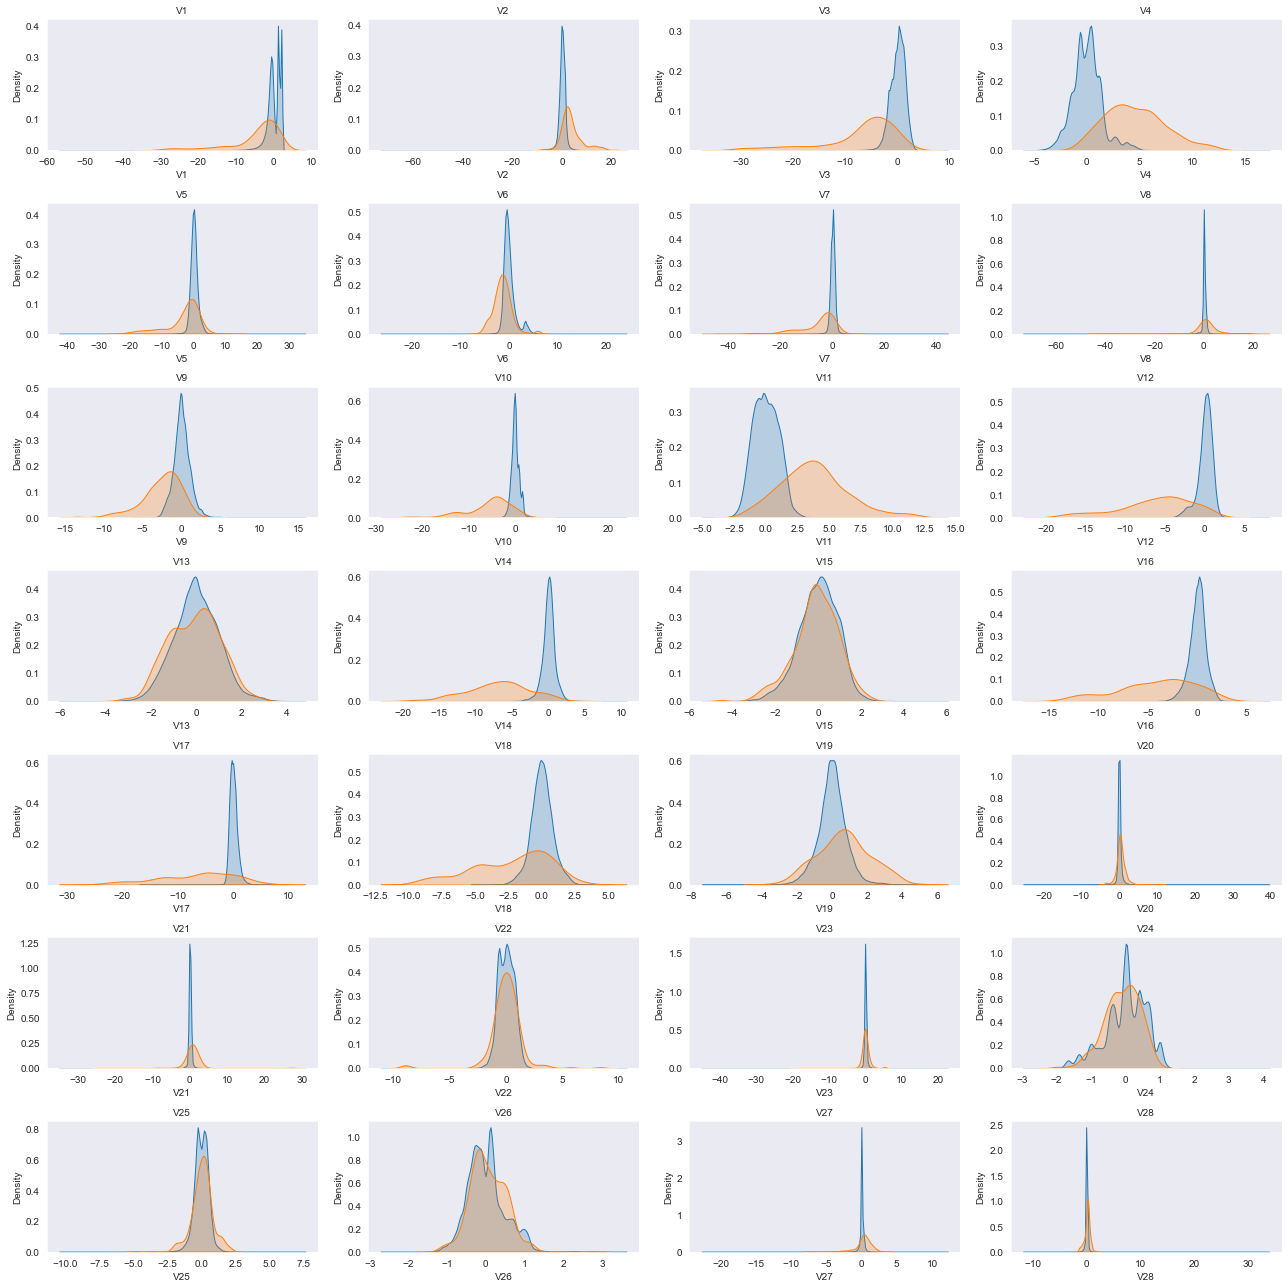

In [10]:
column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
    sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()


Resumidamente, algumas observações principais que puderam ser extraídas dessa etapa exploratória foram:

* O *dataset* está muito desbalanceado, uma vez que as transações fraudulentas representam apenas 0,17% das entradas totais.
* Não existem valores ausentes ou nulos no *dataframe*.
* Uma vez que a PCA é sensível à escala das variáveis, assume-se a premissa que as *features* originais foram padronizadas.
* As colunas `Time` e `Amount` não estão normalizadas.

## Preparando os dados

Para que os dados possam alimentar o modelo de Regressão Logística que iremos construir, nesta etapa de preparação iremos:

* Padronizar as *features* `Time` e `Amount`, que estão em outra ordem de grandeza.
* Dividir entre dados de treino e teste
* Balancear os dados a fim de evitar uma baixa performance para a classe 1 e *overfitting*.

**Padronizar `Time` e `Amount`**

Para esta etapa, uma vez que a coluna `Amount` possui *outliers* será usada a padronização por meio da classe `StandardScaler`.

In [11]:
# padronizar as colunas Time e Amount
df_clean = df.copy()

std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

# ver as primeiras entradas
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.246341,-1.997399
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.346945,-1.997399
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.171178,-1.997378
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140872,-1.997378
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.075195,-1.997357


**Dividir entre conjuntos de Treino e Validação**

Antes de proceder com o balanceamento de dados, devemos splitar os dados já existentes entre Treino e Validação. Caso contrário, não teremos parâmetros para conferir se o balanceamento foi adequado.

Para garantir que os conjuntos de Treino e Validação tenham a mesma quantidade de classes proporcionalmente, passamos `stratify=True`.

In [12]:
# separar variáveis entre X e y
X = df_clean.drop('Class', axis=1)
y = df['Class']

# dividir o dataset entre treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, shuffle=True)

**Balanceamento dos dados**

Usando a biblioteca `imblearn` é possível aplicar facilmente técnicas de balanceamento de dados. No caso, a opção neste projeto foi usar *Under-sampling*, preservando a classe minoritária.

É fácil ver que não há mais aquela discrepância inicial (gráfico de barras no início deste *notebook*).

1    313
0    313
Name: Class, dtype: int64


C:\Users\joao\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


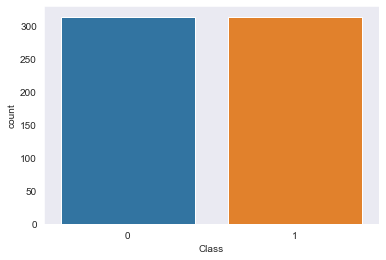

In [25]:
# usar técnica under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

# plotar a nova distribuição de classes
sns.countplot(y_rus);

Com os dados balanceados, podemos ver a matriz de correlação e identificar quais variáveis estão mais fortemente relacionadas com as outras.
Observe como anteriormente, sem o balanceamento de dados, a matriz de correlação não trazia nenhuma informação relevante. Entretanto, ela traz muito mais informações após um correto balanceamento.

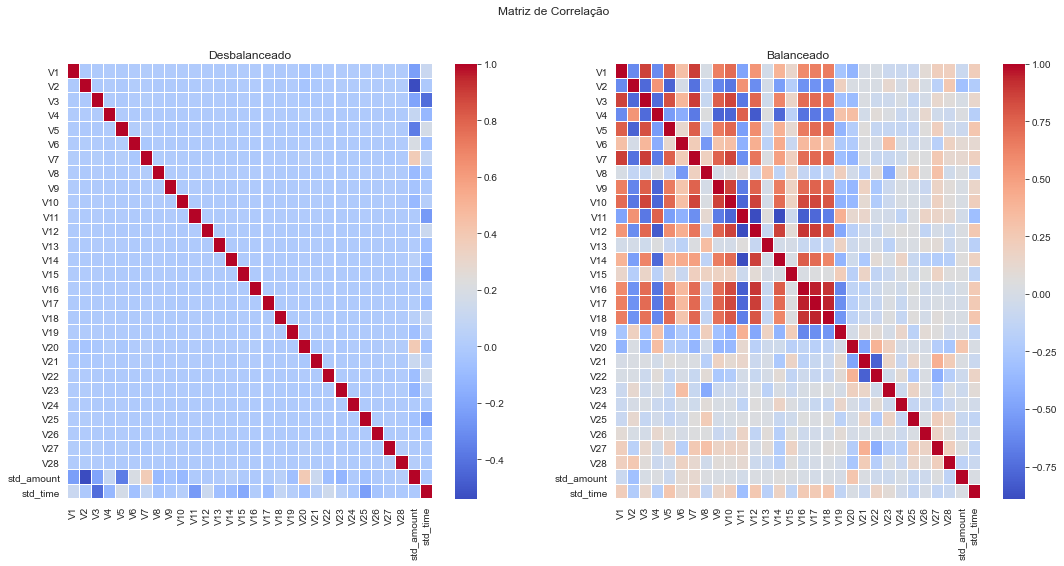

In [26]:
# plotar a matriz de correlação
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[0])
ax[0].set_title('Desbalanceado')

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[1])
ax[1].set_title('Balanceado')

plt.show()

## Modelo de Machine Learning

Com todos os dados preparados e após uma análise exploratória completa, irei construir um classificador usando a Regressão Logística.

Após instanciar o modelo, o mesmo será treinado em cima dos dados em `X_rus` e `y_rus`. Na sequência, serão realizadas as previsões sobre os dados de teste.

In [27]:
# instanciar e treinar um modelo de Regressão Logística
np.random.seed(2)
model = LogisticRegression()
model.fit(X_rus, y_rus)

# fazer as previsões em cima dos dados de teste
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

Com o modelo treinado e as previsões feitas, parte-se para a avaliação do desempenho.

Neste tipo de problema, originalmente desbalanceado, a acurácia não é uma métrica adequada. Como expliquei [neste artigo](http://sigmoidal.ai/como-lidar-com-dados-desbalanceados/), você pode ter uma acurácia de 99,88% e detectar menos de 60% das fraudes.

Observe a matriz de confusão para ver a taxa de acertos para transações fraudulentes, ou pela coluna *recall* do Relatório de Classificação. 

Uma outra métrica considerada interessante para se avaliar a eficácia é a [AUC ROC](https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772), ou área sob a curva. No caso desse modelo de Regressão Logística, tem-se 96% de AUC.

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9644    0.9818     60417
           1     0.0419    0.8952    0.0800       105

    accuracy                         0.9643     60522
   macro avg     0.5208    0.9298    0.5309     60522
weighted avg     0.9981    0.9643    0.9802     60522

Acurácia: 0.9643

AUC: 0.9298



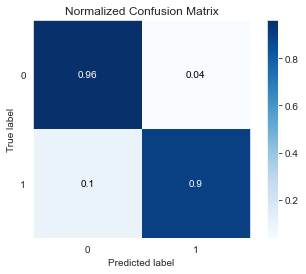

In [28]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_val, y_pred, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_val, y_pred)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_val, y_pred)))

## Fazendo Previsões no Conjunto de Teste

No começo do projeto, realizamos um split nos dados para que tivéssemos 3 conjuntos: Um de treino, um de validação e um de teste. 

Agora que já exploramos e preparamos os dados, instaciamos o modelo e fizemos previsões no conjunto de validação, é hora de descobrirmos o potencial desse simples modelo com os dados de teste.

O que faremos é apenas utilizar o modelo que treinamos com um novo conjunto. Mas, para que os resultados sejam justos, precisamos fazer com que os novos dados estejam nas mesmas condições daqueles que o nosso modelo espera.

Nesse caso, precisamos padronizar as colunas Time e Amount. Não podemos balancear os dados pois haveria perda. Nosso modelo precisa ser tratado mas precisamos fazer previsões em todas as linhas que ele receber.


In [29]:
# padronizar as colunas Time e Amount - Teste
test_clean = test.copy()

std_scaler = StandardScaler()
test_clean['std_amount'] = std_scaler.fit_transform(test_clean['Amount'].values.reshape(-1, 1))
test_clean['std_time'] = std_scaler.fit_transform(test_clean['Time'].values.reshape(-1, 1))

test_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

# ver as primeiras entradas
test_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
183484,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,-1.644401,...,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,0,-0.177738,0.658372
255448,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,-1.192404,...,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,0,-0.321945,1.320094
244749,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,-0.219013,...,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,0,0.034666,1.219742
63919,-2.477184,0.860613,1.441850,1.051019,-1.856621,2.078384,0.510828,-0.243399,-0.260691,0.133040,...,0.692245,0.150121,-0.260777,0.005183,-0.177847,-0.510060,-0.660533,0,0.838765,-0.919236
11475,1.338831,-0.547264,0.737389,-0.212383,-1.110039,-0.525744,-0.801403,-0.063672,0.997276,0.113386,...,-0.074719,0.067055,0.333122,0.379087,-0.268706,-0.002769,0.003272,0,-0.310490,-1.572827


Agora basta separar entre X e Y, e fazer nossas previsões.

In [30]:
# separar variáveis entre X e y
X_test = test_clean.drop('Class', axis=1)
y_test = test['Class']

In [31]:
# fazer as previsões em cima dos dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Pronto! Com nossas previsões feitas, é hora de visualizar os resultados.

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9642    0.9817     42647
           1     0.0438    0.9459    0.0837        74

    accuracy                         0.9641     42721
   macro avg     0.5219    0.9551    0.5327     42721
weighted avg     0.9982    0.9641    0.9802     42721

Acurácia: 0.9641

AUC: 0.9551



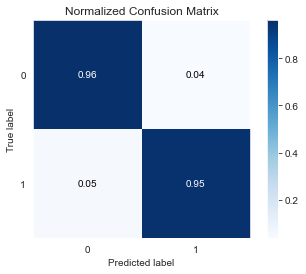

In [32]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Podemos ver que nossos resultados foram marginalmente inferiores ao do conjunto de validação, o que é um excelente resultado!

## Conclusões

Como você pode observar, não se trata de um problema trivial. Apesar dos dados estarem bem tratados e limpos, sem valores ausentes ou variáveis categóricas, o desbalanceamento e a Transformação PCA demandaram um trabalho considerável.

Obviamente, apesar do bom resultado final, há espaço para testar o desempenho com outros algoritmos de classificação, além de otimizar seus parâmetros.

